# Classificação de Texto

Classificação de texto é uma das tarefas mais comuns em NLP. 

Neste notebook, classificaremos os textos da base ReutersGrain, que contém notícias sobre o mercado de grãos.

## Importando bibliotecas necessárias

In [1]:
import csv
import pandas as pd
import nltk

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Carregando a base de dados

Precisamos definir uma função para carregar a base de dados, pois existem vírgulas dentro do próprio texto, o que pode atrapalhar a leitura do arquivo.

In [3]:
# Function to parse the CSV file considering the special structure
def parse_csv(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        reader = csv.reader(file, quotechar="'", escapechar='\\')
        next(reader)  # Skip header
        for row in reader:
            if len(row) == 2:
                data.append(row)
            else:
                # Handle cases where the text contains commas
                text = ','.join(row[:-1])
                classification = row[-1]
                data.append([text, classification])
    return pd.DataFrame(data, columns=['Text', 'Classification'])

In [4]:
# Parsing the file
parsed_train_data = parse_csv("data/train.csv")
parsed_test_data = parse_csv("data/test.csv")

# Print the dimensions of train and test data
print("Train data dimensions: ", parsed_train_data.shape)
print("Test data dimensions: ", parsed_test_data.shape)

Train data dimensions:  (1554, 2)
Test data dimensions:  (604, 2)


## Separando os dados em treino e teste

In [7]:
X_train = parsed_train_data['Text']
y_train = parsed_train_data['Classification']

X_test = parsed_test_data['Text']
y_test = parsed_test_data['Classification']

## Pré-processamento dos dados

In [8]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Downloading the necessary NLTK data
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pedro\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pedro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Para o pré-processamento dos dados, vamos utilizar o pacote NLTK.

Serão realizadas as seguintes etapas:

- Tokenização
- Conversão para minúsculas
- Remoção de pontuação e caracteres especiais
- Remoção de stopwords
- Stemming

In [9]:
def preprocess_text(text):
    '''
    Takes in a string of text, then performs the following:
    1. Tokenizes the sentence into words
    2. Removes non-alphabetic characters
    3. Converts all characters to lowercase
    4. Removes stopwords
    5. Stems the words
    6. Joins the stemmed words back into one string
    '''
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words("english"))
    filtered_tokens = [token.lower() for token in tokens if token.isalpha() and token.lower() not in stop_words]
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]
    return " ".join(stemmed_tokens)

In [10]:
# Preprocessing the training data
X_train_preprocessed = [preprocess_text(text) for text in X_train]

# Preprocessing the test data
X_test_preprocessed = [preprocess_text(text) for text in X_test]

## Vetorização dos dados

Modelos de aprendizado de máquina não conseguem lidar com dados textuais. Portanto, precisamos transformar os textos em vetores numéricos.

Aqui, utilizaremos o modelo TF-IDF para vetorizar os textos.

O modelo TF-IDF é uma combinação de duas métricas: TF (Term Frequency) e IDF (Inverse Document Frequency).

A métrica TF mede a frequência de um termo em um documento. A métrica IDF mede a importância de um termo em um conjunto de documentos.

A importância de um termo aumenta proporcionalmente à medida que o número de ocorrências do termo no documento aumenta. No entanto, a importância do termo diminui à medida que o número de ocorrências do termo em outros documentos aumenta.

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Creating the TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fitting the vectorizer to the training data
X_train_transformed = vectorizer.fit_transform(X_train_preprocessed)

Note que precisamos usar o mesmo modelo de vetorização para os dados de treino e teste.

Caso contrário, as dimensões resultantes não seriam compatíveis.

In [12]:
# Transforming the test data
X_test_transformed = vectorizer.transform(X_test_preprocessed)

## Definindo o modelo

Para classificar os textos, utilizaremos o modelo Multinomial Naive Bayes.

Este modelo é baseado no Teorema de Bayes e é muito utilizado para classificação de textos.

Multinomial Naive Bayes é uma versão do modelo Naive Bayes que utiliza a distribuição multinomial para calcular a probabilidade de um documento pertencer a uma classe.

In [13]:
from sklearn.naive_bayes import MultinomialNB

# Creating the classifier
classifier = MultinomialNB()

# Training the classifier
classifier.fit(X_train_transformed, y_train)

# Making predictions on the test data
y_pred = classifier.predict(X_test_transformed)

# Evaluating the model
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)

Accuracy: 0.9056291390728477


Utilizando GridSearch e Cross Validation, procuramos os melhores parâmetros para o modelo.

In [14]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'alpha': [0.01, 0.1, 0.5, 1.0, 10.0],
}

# Create a GridSearchCV object
grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the data
grid_search.fit(X_train_transformed, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Train a new classifier using the best parameters
classifier = MultinomialNB(alpha=best_params['alpha'])
classifier.fit(X_train_transformed, y_train)

# Make predictions on the test data
y_pred = classifier.predict(X_test_transformed)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.945364238410596


## Gradient Boosting

Gradient Boosting é um algoritmo de aprendizado de máquina que utiliza árvores de decisão como base para construir um modelo preditivo.

O algoritmo Gradient Boosting constrói um modelo aditivo de forma progressiva, ou seja, adiciona uma árvore de decisão de cada vez ao modelo.

Vamos utilizar o algoritmo Gradient Boosting para classificar os textos.

In [15]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

# Create a GradientBoostingClassifier object
classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1)

# Perform 5-fold cross-validation
scores = cross_val_score(classifier, X_train_transformed, y_train, cv=5)

# Print the cross-validation scores
print("Cross-validation scores:", scores)

# Print the mean cross-validation score
print("Mean cross-validation score:", scores.mean())

# Fit the classifier to the data
classifier.fit(X_train_transformed, y_train)

# Make predictions on the test data
y_pred = classifier.predict(X_test_transformed)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Cross-validation scores: [0.97427653 0.99356913 0.96784566 0.95819936 0.99032258]
Mean cross-validation score: 0.9768426511772637
Accuracy: 0.9784768211920529


Podemos melhorar a performance do modelo alterando alguns parâmetros.

Faremos isso através de GridSearch e Cross Validation.

In [16]:
from sklearn.ensemble import GradientBoostingClassifier

# Define the parameter grid
param_grid = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.1, 1.0],
    "max_depth": [1, 3, 5],
}

# Create a GridSearchCV object
grid_search = GridSearchCV(
    GradientBoostingClassifier(), param_grid, cv=5, scoring="accuracy", n_jobs=3
)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train_transformed, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Train a new classifier using the best parameters
classifier = GradientBoostingClassifier(
    n_estimators=best_params["n_estimators"],
    learning_rate=best_params["learning_rate"],
    max_depth=best_params["max_depth"],
)
classifier.fit(X_train_transformed, y_train)

# Make predictions on the test data
y_pred = classifier.predict(X_test_transformed)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9900662251655629


Utilizando GridSearch e Cross Validation, obtivemos, para o modelo de Gradient Boosting, os seguintes parâmetros:

```
{'learning_rate': 1.0, 'max_depth': 5, 'n_estimators': 200}
```

A acurácia do modelo foi de 0.99, a melhor até agora.

A seguir, exibimos a matriz de confusão do modelo.

<Axes: >

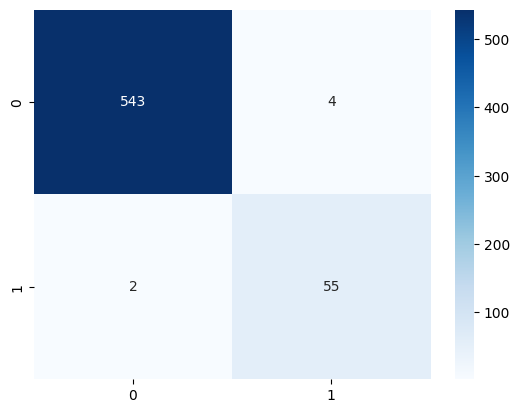

In [18]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
